In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, shutil, random
from tqdm import tqdm

In [3]:
CONFIG = {
    'image_size': (224, 224),
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 100,
    'patience': 5,
    'min_lr': 1e-6,
    'weight_decay': 1e-4,
    'img_shape': (224, 224, 3),
}

In [4]:
SOURCE_DIR = '/kaggle/input/maizeleaf/MaizeLeafDataset'
TARGET_DIR = '/kaggle/working/split_data'

In [5]:
CLASSES = sorted(os.listdir(SOURCE_DIR))
print("Classes:", CLASSES)

Classes: ['Common Rust', 'Gray Leaf Spot', 'Healthy', 'Northern Leaf Blight', 'Not Maize Leaf']


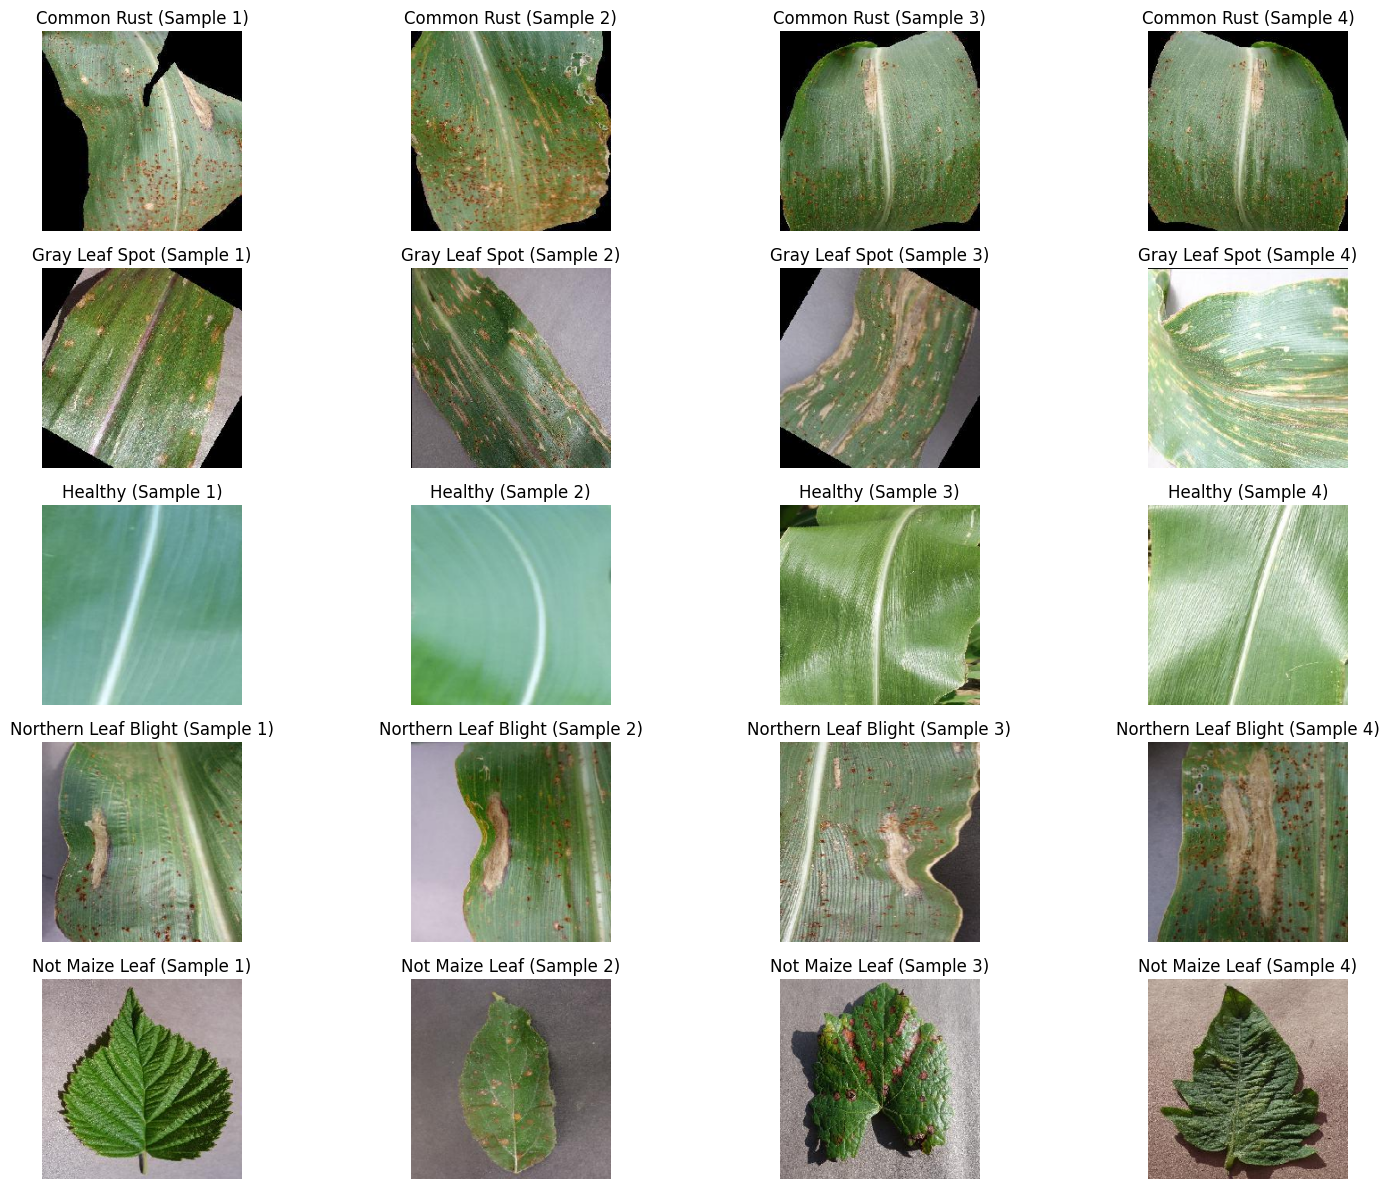

In [6]:
IMG_SIZE = (224, 224)
SAMPLES_PER_CLASS = 4

plt.figure(figsize=(16, 12))

for idx, label in enumerate(CLASSES):
    class_dir = os.path.join(SOURCE_DIR, label)
    images = os.listdir(class_dir)[:SAMPLES_PER_CLASS]
    
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=IMG_SIZE)
        
        plt.subplot(len(CLASSES), SAMPLES_PER_CLASS, idx * SAMPLES_PER_CLASS + i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{label} (Sample {i+1})", fontsize=12)

plt.tight_layout()
plt.show()

In [7]:
SPLITS = ['train', 'val', 'test']

for split in SPLITS:
    for class_name in CLASSES:
        os.makedirs(os.path.join(TARGET_DIR, split, class_name), exist_ok=True)

for class_name in tqdm(CLASSES):
    class_path = os.path.join(SOURCE_DIR, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)
    n_test = n_total - n_train - n_val

    train_files = images[:n_train]
    val_files = images[n_train:n_train + n_val]
    test_files = images[n_train + n_val:]

    for fname in train_files:
        shutil.copy(os.path.join(class_path, fname), os.path.join(TARGET_DIR, 'train', class_name, fname))
    for fname in val_files:
        shutil.copy(os.path.join(class_path, fname), os.path.join(TARGET_DIR, 'val', class_name, fname))
    for fname in test_files:
        shutil.copy(os.path.join(class_path, fname), os.path.join(TARGET_DIR, 'test', class_name, fname))

100%|██████████| 5/5 [00:33<00:00,  6.78s/it]


In [8]:
def get_data_generators(train_dir, val_dir, test_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=(0.8, 1.2),
        zoom_range=0.2,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=CONFIG['image_size'],
        batch_size=CONFIG['batch_size'],
        class_mode='categorical'
    )
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=CONFIG['image_size'],
        batch_size=CONFIG['batch_size'],
        class_mode='categorical',
        shuffle=False
    )
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=CONFIG['image_size'],
        batch_size=CONFIG['batch_size'],
        class_mode='categorical',
        shuffle=False
    )
    return train_generator, val_generator, test_generator

train_dir = os.path.join(TARGET_DIR, 'train')
val_dir = os.path.join(TARGET_DIR, 'val')
test_dir = os.path.join(TARGET_DIR, 'test')

train_gen, val_gen, test_gen = get_data_generators(train_dir, val_dir, test_dir)
CONFIG['num_classes'] = train_gen.num_classes
print(f"\n NUM_CLASSES detected: {CONFIG['num_classes']}")

Found 7079 images belonging to 5 classes.
Found 882 images belonging to 5 classes.
Found 891 images belonging to 5 classes.

 NUM_CLASSES detected: 5


In [9]:
def cbam_block(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]

    # Channel Attention
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    max_pool = layers.GlobalMaxPooling2D()(input_feature)

    shared_mlp = models.Sequential([
        layers.Dense(channel // reduction_ratio, activation='relu', kernel_regularizer=regularizers.l2(CONFIG['weight_decay'])),
        layers.Dense(channel, kernel_regularizer=regularizers.l2(CONFIG['weight_decay']))
    ])

    avg_out = shared_mlp(avg_pool)
    max_out = shared_mlp(max_pool)
    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, channel))(channel_attention)
    channel_refined = layers.Multiply()([input_feature, channel_attention])

    # Spatial Attention
    avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    refined_feature = layers.Multiply()([channel_refined, spatial_attention])

    return refined_feature

In [10]:
def build_model():
    inputs = layers.Input(shape=CONFIG['img_shape'])
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=CONFIG['img_shape'])
    base_model.trainable = True  

    x = base_model(inputs, training=False)
    x = cbam_block(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(CONFIG['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(CONFIG['weight_decay']))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(CONFIG['num_classes'], activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

In [11]:
#Build the model
model = build_model()

I0000 00:00:1752316872.015871      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752316872.016626      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
def train_model(model, train_generator, val_generator):
    model.compile(
        optimizer=optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=CONFIG['patience'], restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=CONFIG['min_lr'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=CONFIG['epochs'],
        callbacks=[early_stop, reduce_lr]
    )
    return history

# Train
history = train_model(model, train_gen, val_gen)

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 171s 508ms/step - accuracy: 0.7806 - loss: 1.1526 - val_accuracy: 0.7653 - val_loss: 1.1579 - learning_rate: 0.0010
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 85s 382ms/step - accuracy: 0.9455 - loss: 0.6989 - val_accuracy: 0.8810 - val_loss: 0.8237 - learning_rate: 0.0010
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 85s 381ms/step - accuracy: 0.9658 - loss: 0.6239 - val_accuracy: 0.7540 - val_loss: 1.0201 - learning_rate: 0.0010
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 84s 380ms/step - accuracy: 0.9745 - loss: 0.5829 - val_accuracy: 0.9320 - val_loss: 0.6457 - learning_rate: 0.0010
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 85s 382ms/step - accuracy: 0.9772 - loss: 0.5632 - val_accuracy: 0.8719 - val_loss: 0.7953 - learning_rate: 0.0010
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 85s 383ms/step - accuracy: 0.9746 - loss: 0.5559 - val_accuracy: 0.9546 - val_loss: 0.5741 - learning_rate: 0.0010
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 85s 382ms/step - accur

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size=3):
    """Compute simple moving average."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_training_curves(history, smooth=False, window_size=3):
    """Plot training & validation loss and accuracy curves with optional smoothing."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if smooth:
        acc = moving_average(acc, window_size)
        val_acc = moving_average(val_acc, window_size)
        loss = moving_average(loss, window_size)
        val_loss = moving_average(val_loss, window_size)
        epochs = range(1, len(acc) + 1)
    else:
        epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

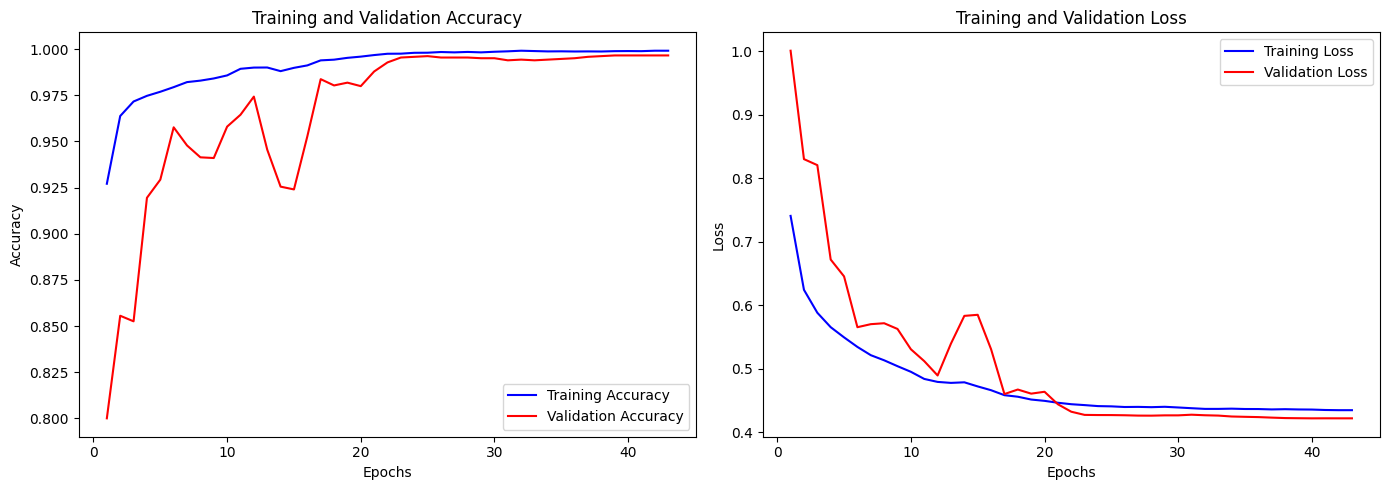

In [25]:
plot_training_curves(history, smooth=True, window_size=3)

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.9937 - loss: 0.4281

 Test Loss: 0.4374
 Test Accuracy: 98.99%
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step

 Overall Test Set Metrics (Weighted Average):
Precision: 0.9903
Recall:    0.9899
F1-score:  0.9899

 Classification Report (Per Class):
                      precision    recall  f1-score   support

         Common Rust       1.00      0.99      1.00       192
      Gray Leaf Spot       0.95      1.00      0.98       165
             Healthy       1.00      1.00      1.00       187
Northern Leaf Blight       0.99      0.96      0.98       192
      Not Maize Leaf       1.00      1.00      1.00       155

            accuracy                           0.99       891
           macro avg       0.99      0.99      0.99       891
        weighted avg       0.99      0.99      0.99       891



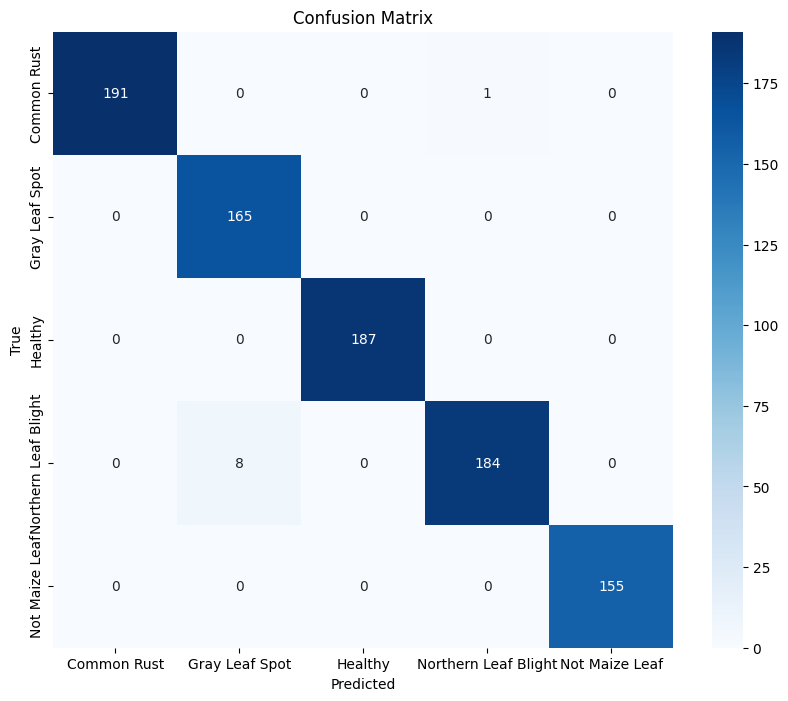

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluation
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n Test Loss: {test_loss:.4f}")
print(f" Test Accuracy: {test_acc*100:.2f}%")

# Predict
test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

#Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Extract weighted average
weighted_precision = report['weighted avg']['precision']
weighted_recall    = report['weighted avg']['recall']
weighted_f1        = report['weighted avg']['f1-score']

print("\n Overall Test Set Metrics (Weighted Average):")
print(f"Precision: {weighted_precision:.4f}")
print(f"Recall:    {weighted_recall:.4f}")
print(f"F1-score:  {weighted_f1:.4f}")


print("\n Classification Report (Per Class):")
print(classification_report(y_true, y_pred, target_names=class_names))

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [17]:
model.save('final_trained_model.h5')

In [18]:
# Define feature extractor directly from trained model
feature_extractor = models.Model(
    inputs=model.input,
    outputs=model.layers[-4].output
)
feature_extractor.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 1280)      │    411,040 │ global_average_p… │
│ (Sequential)        │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1280)      │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1280)      │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ activation[0][0]  │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7, 7,      │          0 │ mobilenetv2_1.00… │
│                     │ 1280)             │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 7, 7, 1)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 7, 7, 1)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 2)   │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 7, 7, 1)   │         99 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 7, 7,      │          0 │ multiply[0][0],   │
│ (Multiply)          │ 1280)             │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,030,979 (11.56 MB)

 Trainable params: 2,996,355 (11.43 MB)

 Non-trainable params: 34,624 (135.25 KB)

In [19]:
# Feature Extraction
datagen = ImageDataGenerator(rescale=1./255)

train_gen_feat = datagen.flow_from_directory(
    train_dir,
    target_size=CONFIG['image_size'],
    batch_size=CONFIG['batch_size'],
    class_mode='sparse',
    shuffle=False
)
test_gen_feat = datagen.flow_from_directory(
    test_dir,
    target_size=CONFIG['image_size'],
    batch_size=CONFIG['batch_size'],
    class_mode='sparse',
    shuffle=False
)

# Extract features
train_features = feature_extractor.predict(train_gen_feat, verbose=1)
test_features = feature_extractor.predict(test_gen_feat, verbose=1)

train_labels = train_gen_feat.classes
test_labels = test_gen_feat.classes

print(" Train features:", train_features.shape)
print(" Test features:", test_features.shape)

Found 7079 images belonging to 5 classes.
Found 891 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step
 Train features: (7079, 128)
 Test features: (891, 128)


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)


 Training SVM...

 SVM Test Accuracy: 99.44%

                      precision    recall  f1-score   support

         Common Rust       1.00      0.99      1.00       192
      Gray Leaf Spot       0.98      1.00      0.99       165
             Healthy       1.00      1.00      1.00       187
Northern Leaf Blight       0.99      0.98      0.99       192
      Not Maize Leaf       1.00      1.00      1.00       155

            accuracy                           0.99       891
           macro avg       0.99      0.99      0.99       891
        weighted avg       0.99      0.99      0.99       891



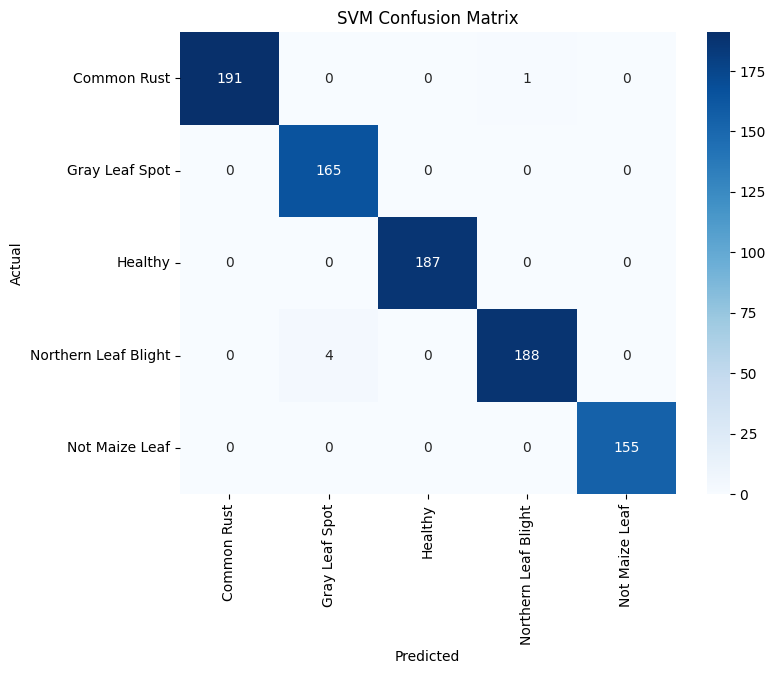

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train SVM with tuned hyperparameters
svm_clf = SVC(
    C=30,                
    gamma='scale',       
    kernel='rbf',        
    probability=True,    
    class_weight='balanced',
    random_state=42
)
print("\n Training SVM...")
svm_clf.fit(train_features_scaled, train_labels)

# Predict
svm_preds = svm_clf.predict(test_features_scaled)

# Accuracy
acc_svm = accuracy_score(test_labels, svm_preds)
print(f"\n SVM Test Accuracy: {acc_svm*100:.2f}%\n")
print(classification_report(test_labels, svm_preds, target_names=CLASSES))

# Confusion Matrix
cm = confusion_matrix(test_labels, svm_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()